In [1]:
# Import basic modules
import numpy as np
import pandas as pd
pd.options.display.max_columns = 1000
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Import learning modules
import statsmodels.api as sm

from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression

import xgboost as xgb
from xgboost import XGBRegressor

In [3]:
# For EDA - scatter plots of each independent variable to dependent variable
def scatterplots(columns, y_col, data, ncol=None, figsize=(15,8)) :
    if ncol == None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = y_col, data = data, alpha=0.5)
        ax.set(xlabel=col, ylabel=y_col)
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [4]:
# For displaying CV result statistics
def test_stat(model, y_true, y_pred):
    print(model, ": ")
    print("R^2: ", r2_score(y_true, y_pred))
    print("RMSE: ", (mean_squared_error(y_true, y_pred)) ** 0.5)

In [5]:
def pred_plot(title, y_pred, y_true, figsize=(8,6)):
    sns.set()
    fig, ax = plt.subplots(figsize=(8,6))

    ax.scatter(y_pred, y_true, color='b', label='predicted')
    ax.plot(y_true, y_true, marker='.', linestyle='-', color='r', label='perfect "model"')

    ax.set_xlabel('predicted')
    ax.set_ylabel('actual')
    ax.set_title(title, fontsize=15)
    ax.legend()

    plt.show()

In [6]:
# Read file
df = pd.read_csv('Data/Written_essay_scores_cleaned.csv')

In [7]:
df['Grade/Degree'].fillna('N/A')
df['Grade/Degree'] = df['Grade/Degree'].astype(str)
df['Acad. Genre'] = df['Acad. Genre'].fillna('N/A')
df['Major/ Occupation'] = df['Major/ Occupation'].fillna('N/A')
df = df.drop(['Total 2 (Weighted %)', 'Unnamed: 0', 'INTM+INSM', 'INTM-INSM', 'Major/ Occupation', 'Code', 
              'Content (/12)', 'Organization (/12)', 'Vocabulary (/12)', 'Language Use (/12)', 'Mechanics (/12)'], axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Total 1 (%)    321 non-null    float64
 1   Country        321 non-null    object 
 2   PTJ1 (wds)     321 non-null    int64  
 3   SMK1 (wds)     321 non-null    int64  
 4   Sex            321 non-null    object 
 5   Age            321 non-null    int64  
 6   Grade/Degree   321 non-null    object 
 7   Acad. Genre    321 non-null    object 
 8   VST            321 non-null    float64
 9   CEFR           321 non-null    object 
 10  INTM           321 non-null    float64
 11  INSM           321 non-null    float64
 12  Primary        321 non-null    float64
 13  Secondary      321 non-null    float64
 14  College        321 non-null    float64
 15  Inschool       321 non-null    float64
 16  Outschool      321 non-null    float64
 17  Listening      321 non-null    float64
 18  Reading   

In [9]:
X = df.drop(['Total 1 (%)'], axis=1).copy()
X = pd.get_dummies(X)

y = df['Total 1 (%)'].copy()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
lr_pipe = make_pipeline(SelectKBest(f_regression), LinearRegression())
params = {'selectkbest__k': [k+1 for k in range(len(X_train.columns))]}
lr_grid_cv = GridSearchCV(lr_pipe, param_grid = params, cv=10, n_jobs=-1)

In [12]:
lr_grid_cv.fit(X_train, y_train)
print(lr_grid_cv.best_params_)
lr_best = lr_grid_cv.best_estimator_

{'selectkbest__k': 5}


In [13]:
lr_best.fit(X_train, y_train)

Pipeline(steps=[('selectkbest',
                 SelectKBest(k=5,
                             score_func=<function f_regression at 0x0000019BF02B4F70>)),
                ('linearregression', LinearRegression())])

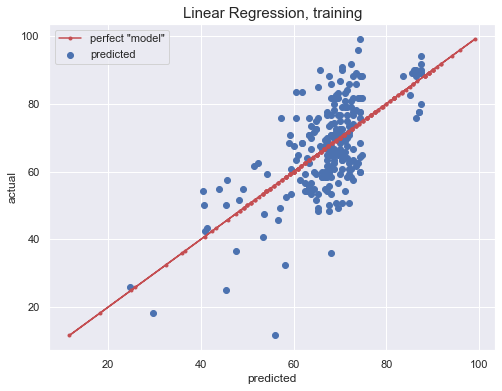

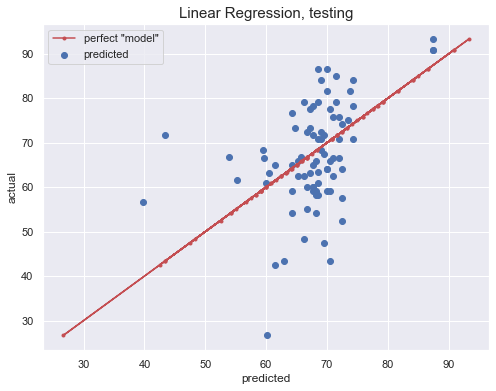

In [14]:
y_tr_lr_pred = lr_best.predict(X_train)
y_te_lr_pred = lr_best.predict(X_test)
pred_plot('Linear Regression, training', y_tr_lr_pred, y_train)
pred_plot('Linear Regression, testing', y_te_lr_pred, y_test)

In [15]:
test_stat("Linear Regression", y_test, y_te_lr_pred)

Linear Regression : 
R^2:  0.16004518014139768
RMSE:  10.826944182881997


In [16]:
rf_pipe = make_pipeline(StandardScaler(), RandomForestRegressor())
grid_params = {
    'randomforestregressor__n_estimators': [int(n) for n in np.logspace(start=1, stop=3, num=5)],
    'randomforestregressor__max_depth': [10, 20, 30, None],
    'standardscaler': [StandardScaler(), None]
}
rf_grid_cv = GridSearchCV(rf_pipe, param_grid=grid_params, cv=10, n_jobs=-1)

In [17]:
rf_grid_cv.fit(X_train, y_train)
print(rf_grid_cv.best_params_)
rf_best = rf_grid_cv.best_estimator_

{'randomforestregressor__max_depth': 10, 'randomforestregressor__n_estimators': 1000, 'standardscaler': None}


In [18]:
pd.DataFrame(rf_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__max_depth,param_randomforestregressor__n_estimators,param_standardscaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
9,4.218676,0.144786,0.129954,0.007543,10,1000,None,"{'randomforestregressor__max_depth': 10, 'rand...",0.020203,0.216933,0.289889,0.430714,0.424428,0.570581,0.523979,0.273633,0.412228,0.353897,0.351649,0.151907,1
35,0.506230,0.023374,0.022695,0.010771,None,100,None,"{'randomforestregressor__max_depth': None, 'ra...",0.012693,0.208859,0.235199,0.404714,0.449622,0.578944,0.587880,0.320326,0.383373,0.313840,0.349545,0.164954,2
39,4.677222,0.621695,0.124710,0.034574,None,1000,None,"{'randomforestregressor__max_depth': None, 'ra...",0.020898,0.236108,0.279601,0.433727,0.414092,0.564066,0.526953,0.278561,0.402671,0.333582,0.349026,0.149207,3
29,4.728281,0.073241,0.144325,0.009805,30,1000,None,"{'randomforestregressor__max_depth': 30, 'rand...",0.024586,0.251636,0.286450,0.393537,0.418501,0.556999,0.533905,0.275947,0.403933,0.343079,0.348857,0.145359,4
27,1.610048,0.059828,0.053518,0.006339,30,316,None,"{'randomforestregressor__max_depth': 30, 'rand...",0.037657,0.232183,0.290160,0.412188,0.401556,0.555312,0.511263,0.287715,0.401642,0.352578,0.348225,0.140081,5


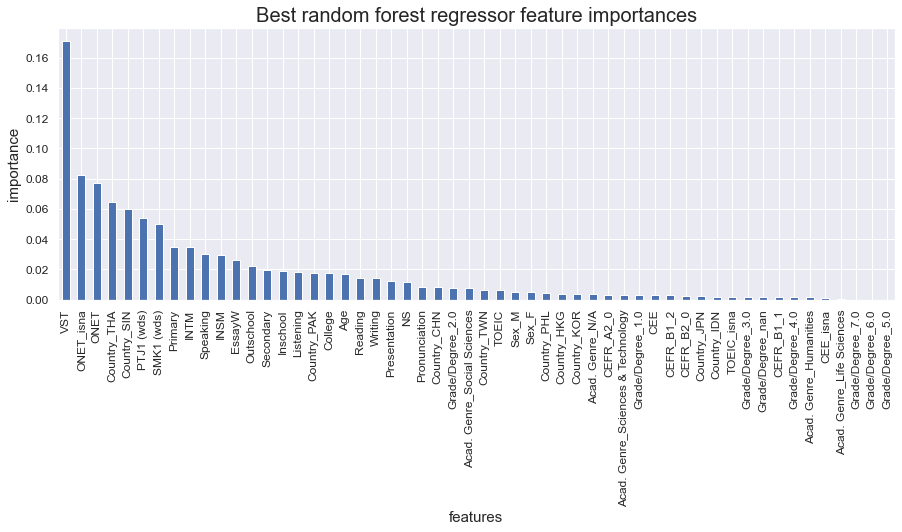

In [19]:
rf_best.fit(X_train, y_train)

plt.subplots(figsize=(15, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar', fontsize=12)
plt.xlabel('features', fontsize=15)
plt.ylabel('importance', fontsize=15)
plt.title('Best random forest regressor feature importances', fontsize=20);

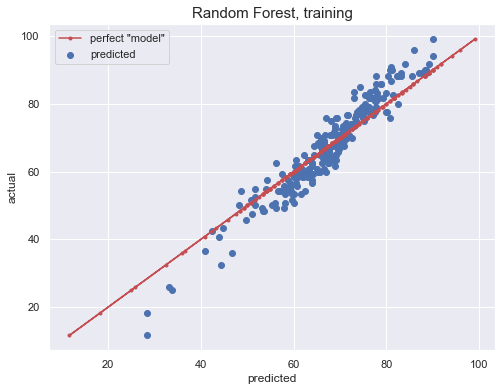

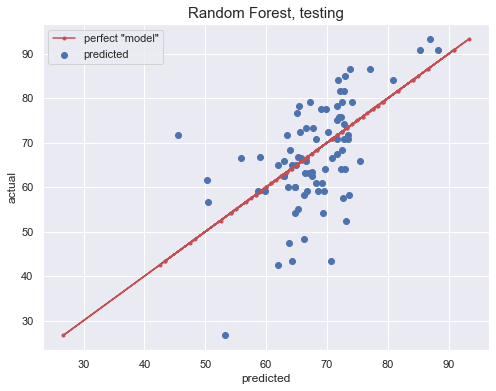

In [20]:
y_tr_rf_pred = rf_best.predict(X_train)
y_te_rf_pred = rf_best.predict(X_test)
pred_plot("Random Forest, training", y_tr_rf_pred, y_train)
pred_plot("Random Forest, testing", y_te_rf_pred, y_test)

In [21]:
test_stat("Random Forest", y_test, y_te_rf_pred)

Random Forest : 
R^2:  0.30049399746919814
RMSE:  9.880380215002518


In [22]:
DM_train = xgb.DMatrix(X_train, y_train)
DM_test = xgb.DMatrix(X_test, y_test)

In [33]:
xg = XGBRegressor(objective='reg:linear', seed=42)
params = {
    'max_depth': range(2, 8, 1),
    'n_estimators': [int(n) for n in np.logspace(start=1, stop=3, num=5)],
    'learning_rate': [1, 0.1, 0.01]
}
xg_grid_cv = GridSearchCV(xg, param_grid=params, cv=10, n_jobs=-1)

In [34]:
xg_grid_cv.fit(X_train, y_train)

[16:20:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None,
                                    objective='reg:linear', random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=42,
             

In [35]:
xg_grid_cv.best_params_

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000}

In [41]:
pd.DataFrame(xg_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
64,2.418270,0.182531,0.006293,0.000903,0.01,2,1000,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.130107,0.311489,0.347695,0.421493,0.430052,0.619856,0.509333,0.228925,0.507618,0.248276,0.375484,0.142452,1
32,0.236663,0.014156,0.004986,0.000447,0.1,2,100,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.156662,0.308725,0.331811,0.420279,0.463191,0.600779,0.500171,0.185551,0.551592,0.225383,0.374414,0.148276,2
69,2.765231,0.195950,0.006199,0.000613,0.01,3,1000,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.100400,0.309608,0.265322,0.392572,0.476561,0.576001,0.584004,0.144217,0.381003,0.237077,0.346676,0.158340,3
33,0.713060,0.028203,0.005342,0.000708,0.1,2,316,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.105548,0.331237,0.335236,0.299312,0.351621,0.599238,0.446231,0.098047,0.587346,0.276669,0.343048,0.160930,4
31,0.100709,0.017171,0.006384,0.001559,0.1,2,31,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.091150,0.362965,0.246523,0.418162,0.422583,0.579654,0.414569,0.202566,0.343505,0.245477,0.332715,0.132068,5


In [36]:
xg_best = xg_grid_cv.best_estimator_

In [37]:
xg_best.fit(X_train, y_train)

[16:21:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

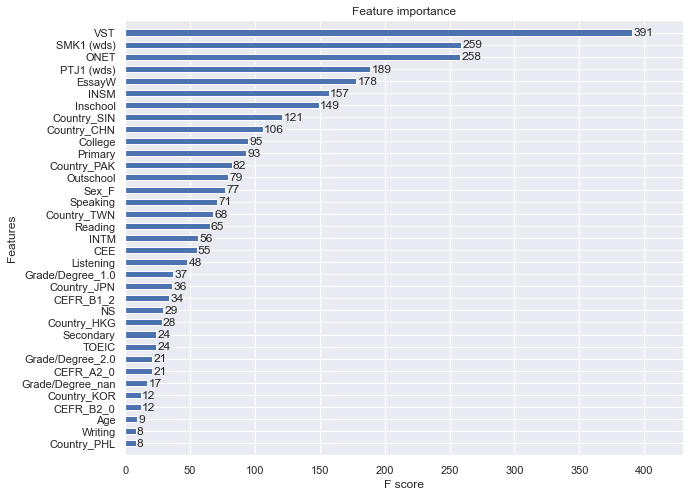

In [38]:
fig, ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(xg_best, ax=ax, height=0.5)
plt.show()

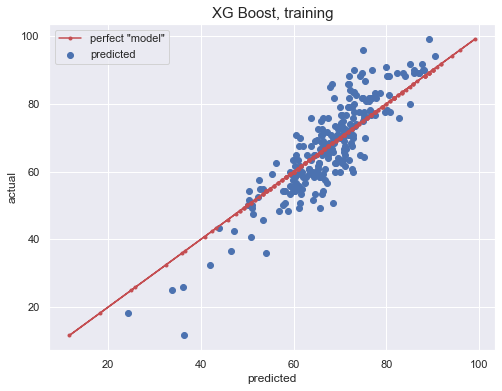

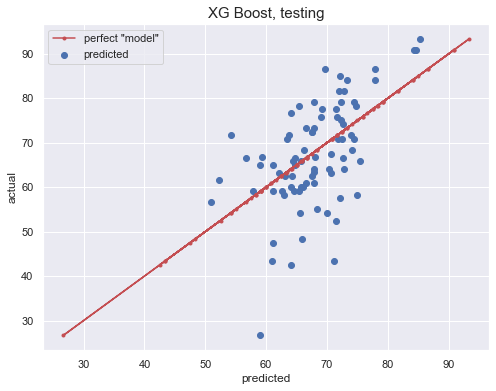

In [39]:
y_tr_xg_pred = xg_best.predict(X_train)
y_te_xg_pred = xg_best.predict(X_test)
pred_plot("XG Boost, training", y_tr_xg_pred, y_train)
pred_plot("XG Boost, testing", y_te_xg_pred, y_test)

In [40]:
test_stat("XG Boost", y_test, y_te_xg_pred)

XG Boost : 
R^2:  0.31021390774100377
RMSE:  9.811494199103258
